In [6]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
import os
import joblib
from scipy.stats import median_abs_deviation
from skyfield.api import load, EarthSatellite
from datetime import datetime, timezone
import numpy as np
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sys.path.append(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\prod_code')
from helpers import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\dataout_HPC\model_test_train.parquet')

In [3]:
unique_ids = df['NORAD_CAT_ID'].unique()
unique_ids.sort()
len(unique_ids)

2544

In [ ]:
def split_data(df, test_size = 0.2, random_state = 42):
    

In [ ]:
def build_anom_model(NORAD_ID_NUM):

    os.makedirs(rf"C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\training_plots\plots_training_{NORAD_ID_NUM}", exist_ok=True)

    samp_df = df[df['NORAD_CAT_ID']==NORAD_ID_NUM]
    samp_df = samp_df.sort_values(by='datetime', ascending=False)
    orb_df = samp_df[['datetime','inclination','ra_of_asc_node', 'eccentricity', 'arg_of_perigee', 'mean_anomaly', 'mean_motion']]
    orb_df = orb_df.set_index('datetime', drop = True)
    

    plot_save_dir = rf"C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\training_plots\plots_training_{NORAD_ID_NUM}"
    feature_names = list(orb_df)
    
    detector, anomalies, explanations, timestamps, anomaly_details = run_anomaly_detection_pipeline(
        orb_df,
        feature_names=feature_names,
        model_path=r"C:\Users\dk412\Desktop\David\Python Projects\RusSat\anomaly_model",
        should_train=True,
        NORAD_ID_NUM=NORAD_ID_NUM,  
        plot_save_dir=plot_save_dir  
    )
    

    return orb_df, detector, anomalies, explanations, samp_df   

unique_ids = df['NORAD_CAT_ID'].unique()[:5]
total_sats = len(unique_ids)

all_orbital_features = ['inclination', 'ra_of_asc_node', 'eccentricity', 'arg_of_perigee', 'mean_anomaly', 'mean_motion']
anom_columns = [f'anom_{feat}' for feat in all_orbital_features]

for count, x in enumerate(unique_ids, 1):
    orb_df, detector, anomalies, explanations, samp_df = build_anom_model(x)
    
    anom_dict = {exp['sample_index']: [feat['feature'] for feat in exp['anomalous_features']] for exp in explanations}    

    full_df = samp_df.copy(deep=False)
    full_df.reset_index(inplace=True, drop = True)

    all_features = set().union(*[set(features) for features in anom_dict.values()]) 
    
    anom_df = pd.DataFrame(0, 
                        index=anom_dict.keys(),
                        columns=anom_columns)

    for key, features in anom_dict.items():
        anom_df.loc[key, [f'anom_{feat}' for feat in features]] = 1

    full_df = full_df.join(anom_df, how='left')

    full_df['anom_count'] = full_df.filter(like='anom_').sum(axis=1)
    full_df = full_df.fillna(0)

    for col in anom_columns:
        if col not in full_df.columns:
            full_df[col] = 0

    mode = 'w' if count == 1 else 'a'
    header = count == 1
    full_df.to_csv(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\anom_df_TRAIN_all_sats.csv', mode=mode, header=header, index=False)
    
    progress = count/df['NORAD_CAT_ID'].nunique()*100
    print(f"\nModel number {count} out of {df['NORAD_CAT_ID'].nunique()} complete. Progress: {progress:.3f}% done\n")

    del full_df, orb_df, detector, anomalies, explanations, samp_df
    del anom_df, anom_dict

Training new model...
Initializing detector with input_dim=6, latent_dim=4
Using device: cpu
Starting training with data shape: (2334, 6)
Training with 73 batches per epoch
Epoch [10/150], Loss: 0.171630
Epoch [20/150], Loss: 0.091181
Epoch [30/150], Loss: 0.041055
Epoch [40/150], Loss: 0.048586
Epoch [50/150], Loss: 0.029293
Epoch [60/150], Loss: 0.031256
Epoch [70/150], Loss: 0.023198
Epoch [80/150], Loss: 0.023892
Epoch [90/150], Loss: 0.043543
Epoch [100/150], Loss: 0.027426
Epoch [110/150], Loss: 0.031350
Epoch [120/150], Loss: 0.024800
Epoch [130/150], Loss: 0.017318
Epoch [140/150], Loss: 0.022804
Epoch [150/150], Loss: 0.016418
Model saved to C:\Users\dk412\Desktop\David\Python Projects\RusSat\anomaly_model
Detecting anomalies...
Detecting anomalies in data with shape: (2334, 6)
Found 322 anomalous samples
Generating explanations...
Generating explanations for shape (2334, 6)
Generated 322 anomaly explanations
Generating visualizations...
Generating visualization summary...

Ge

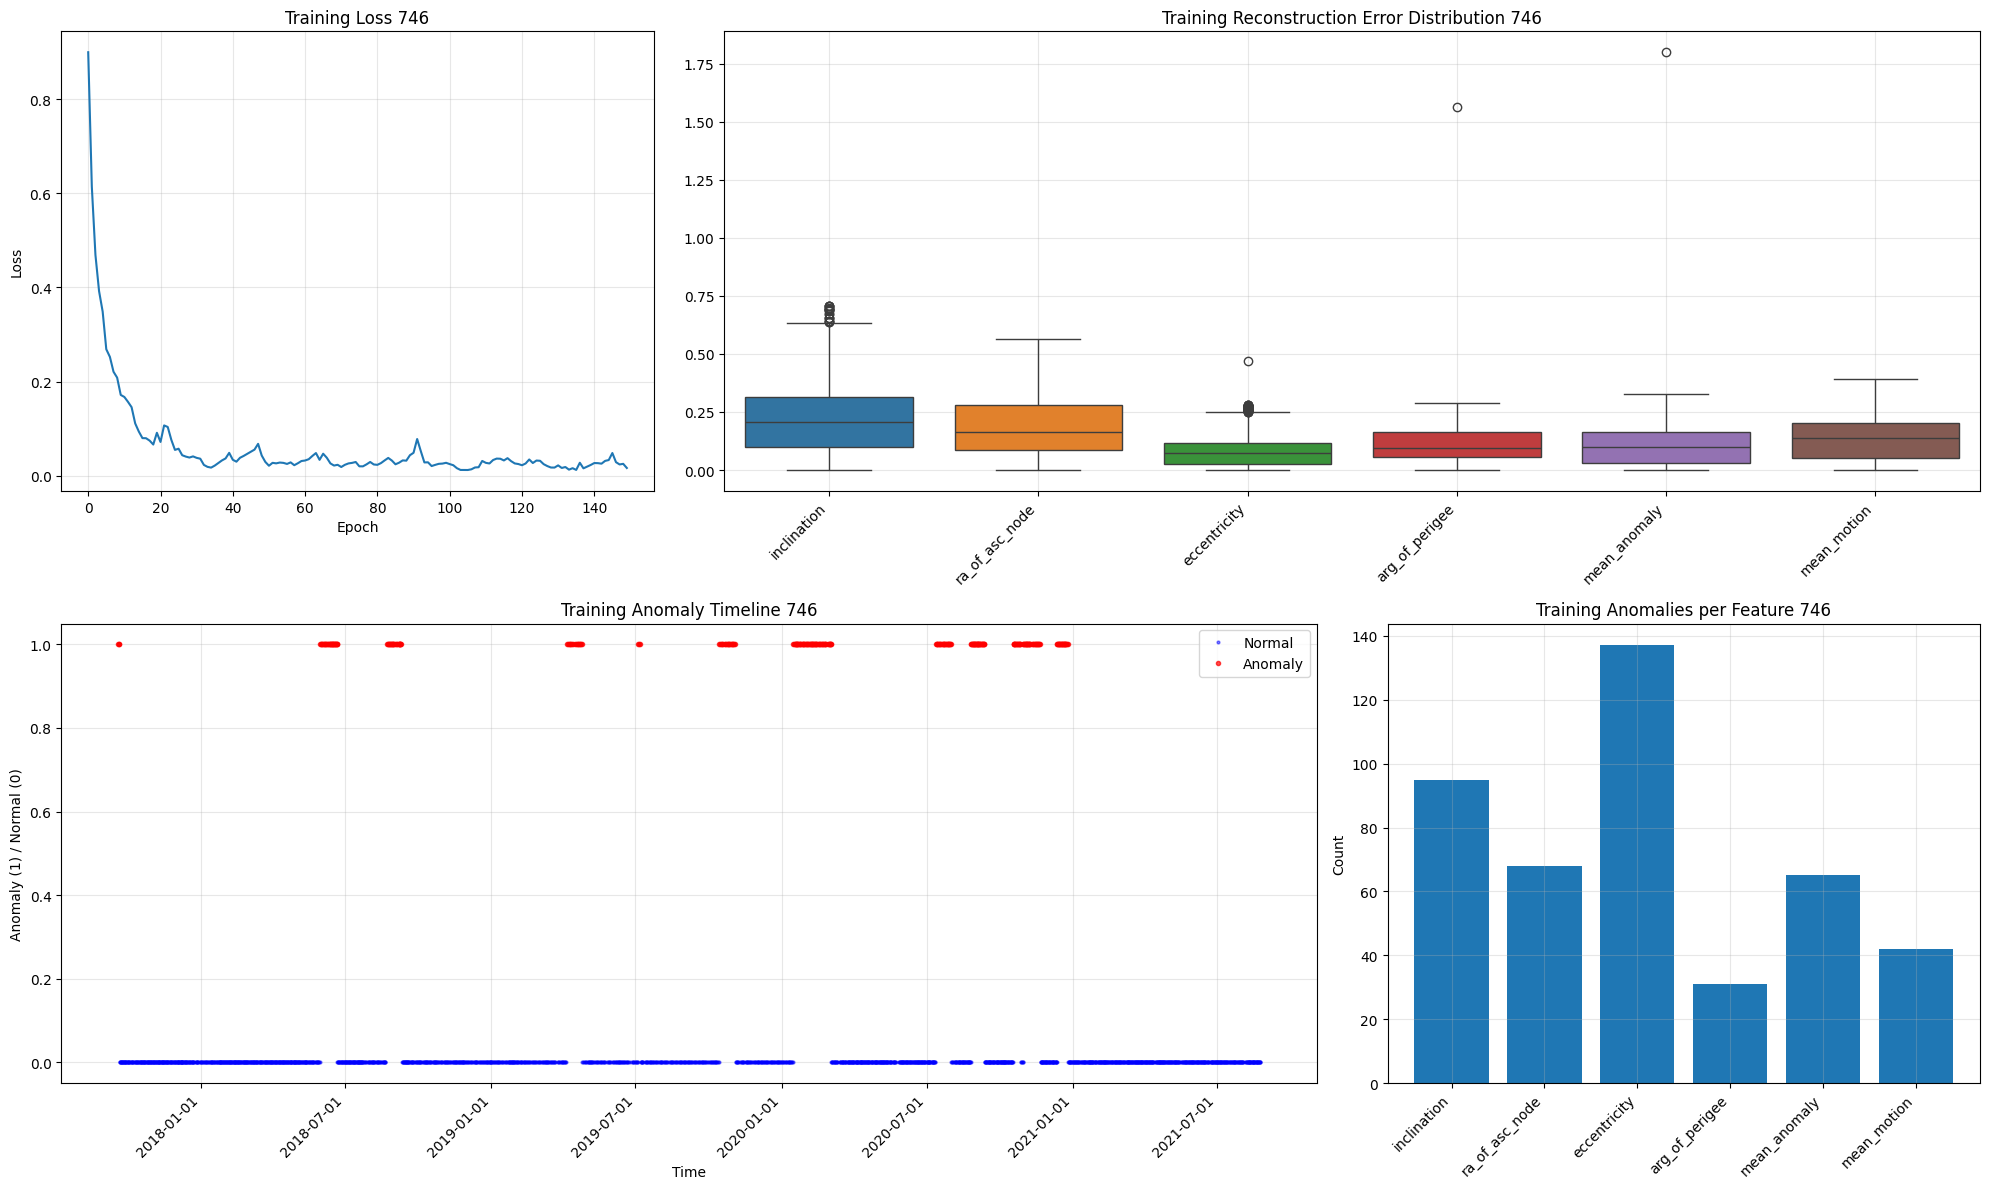

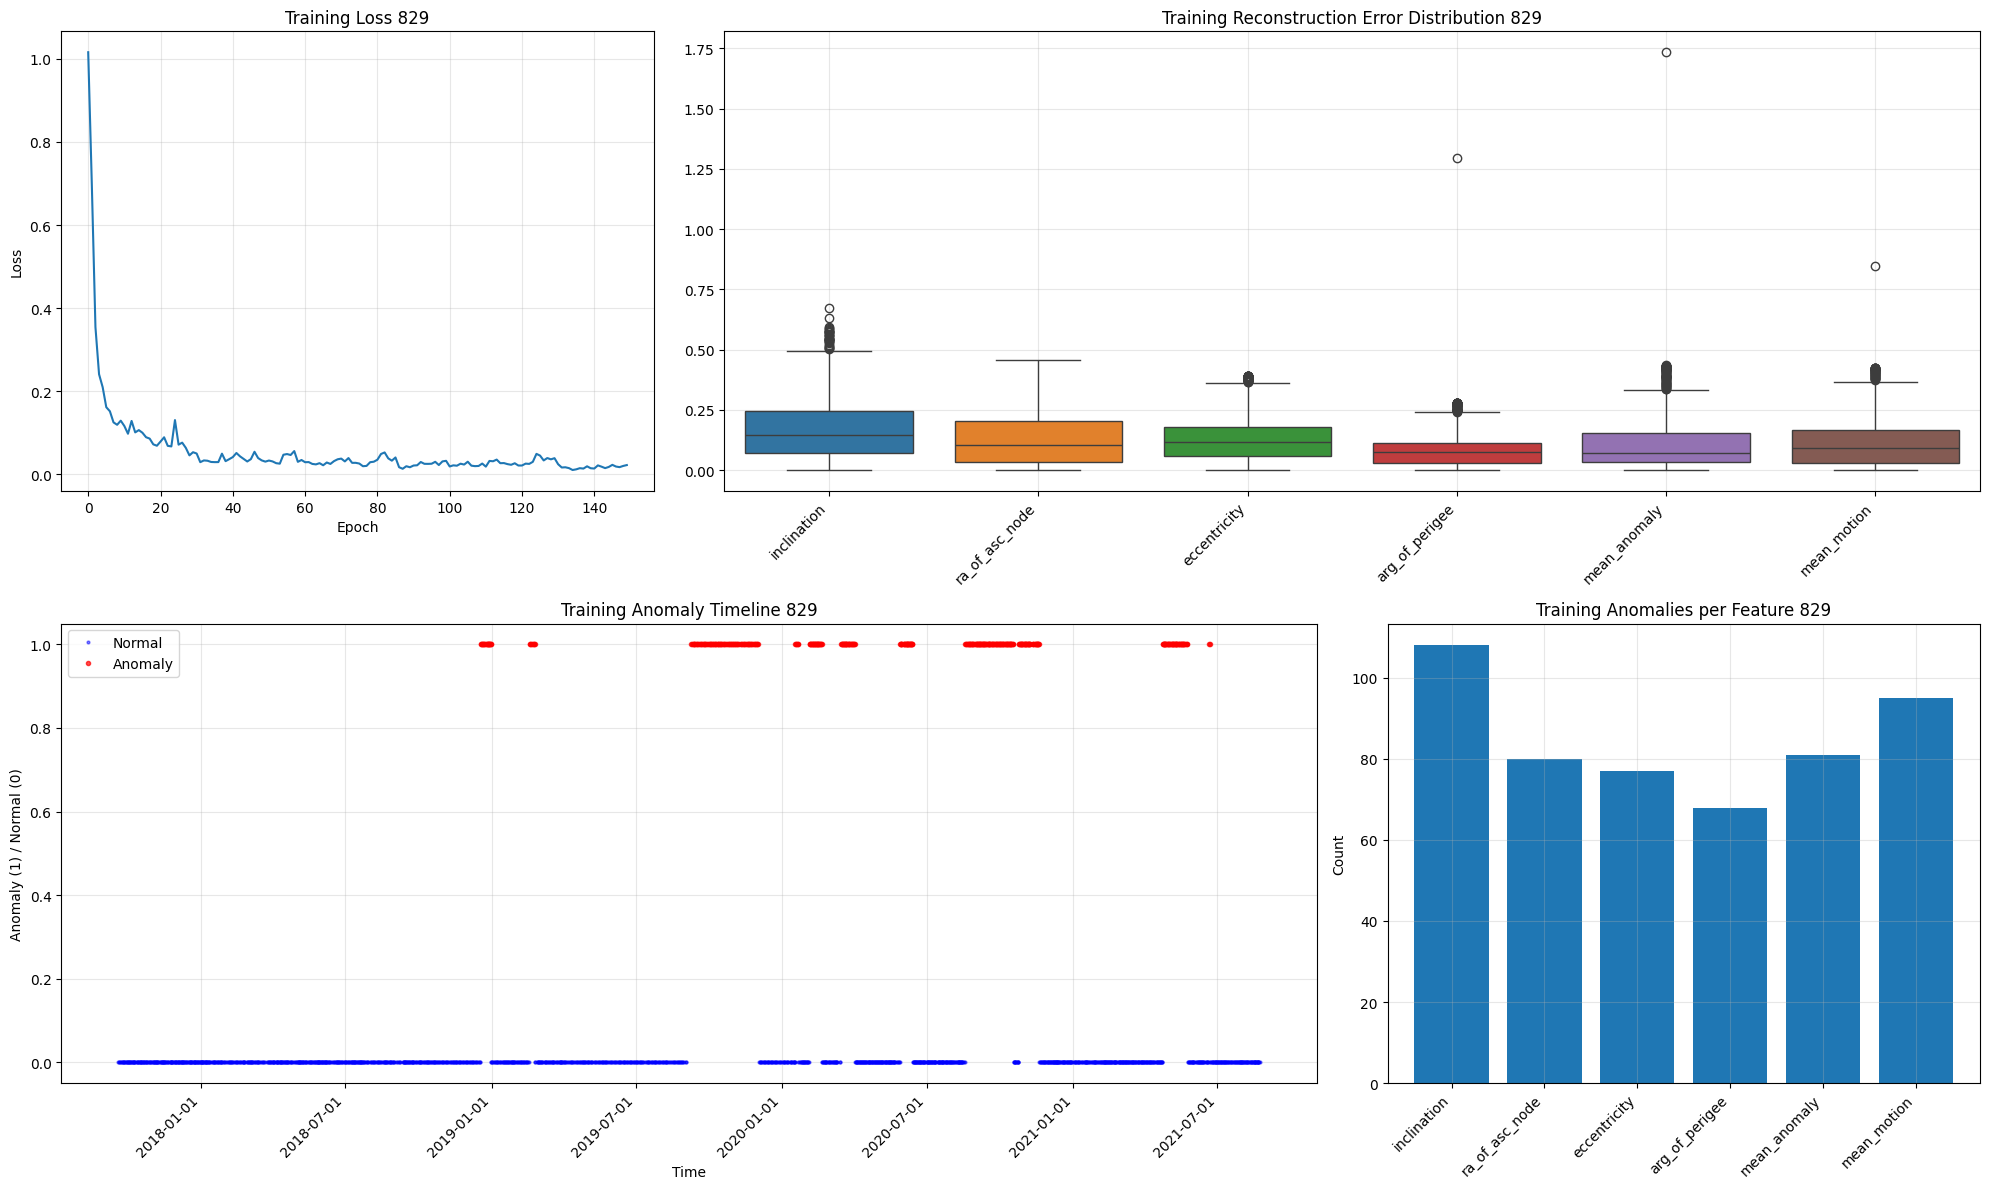

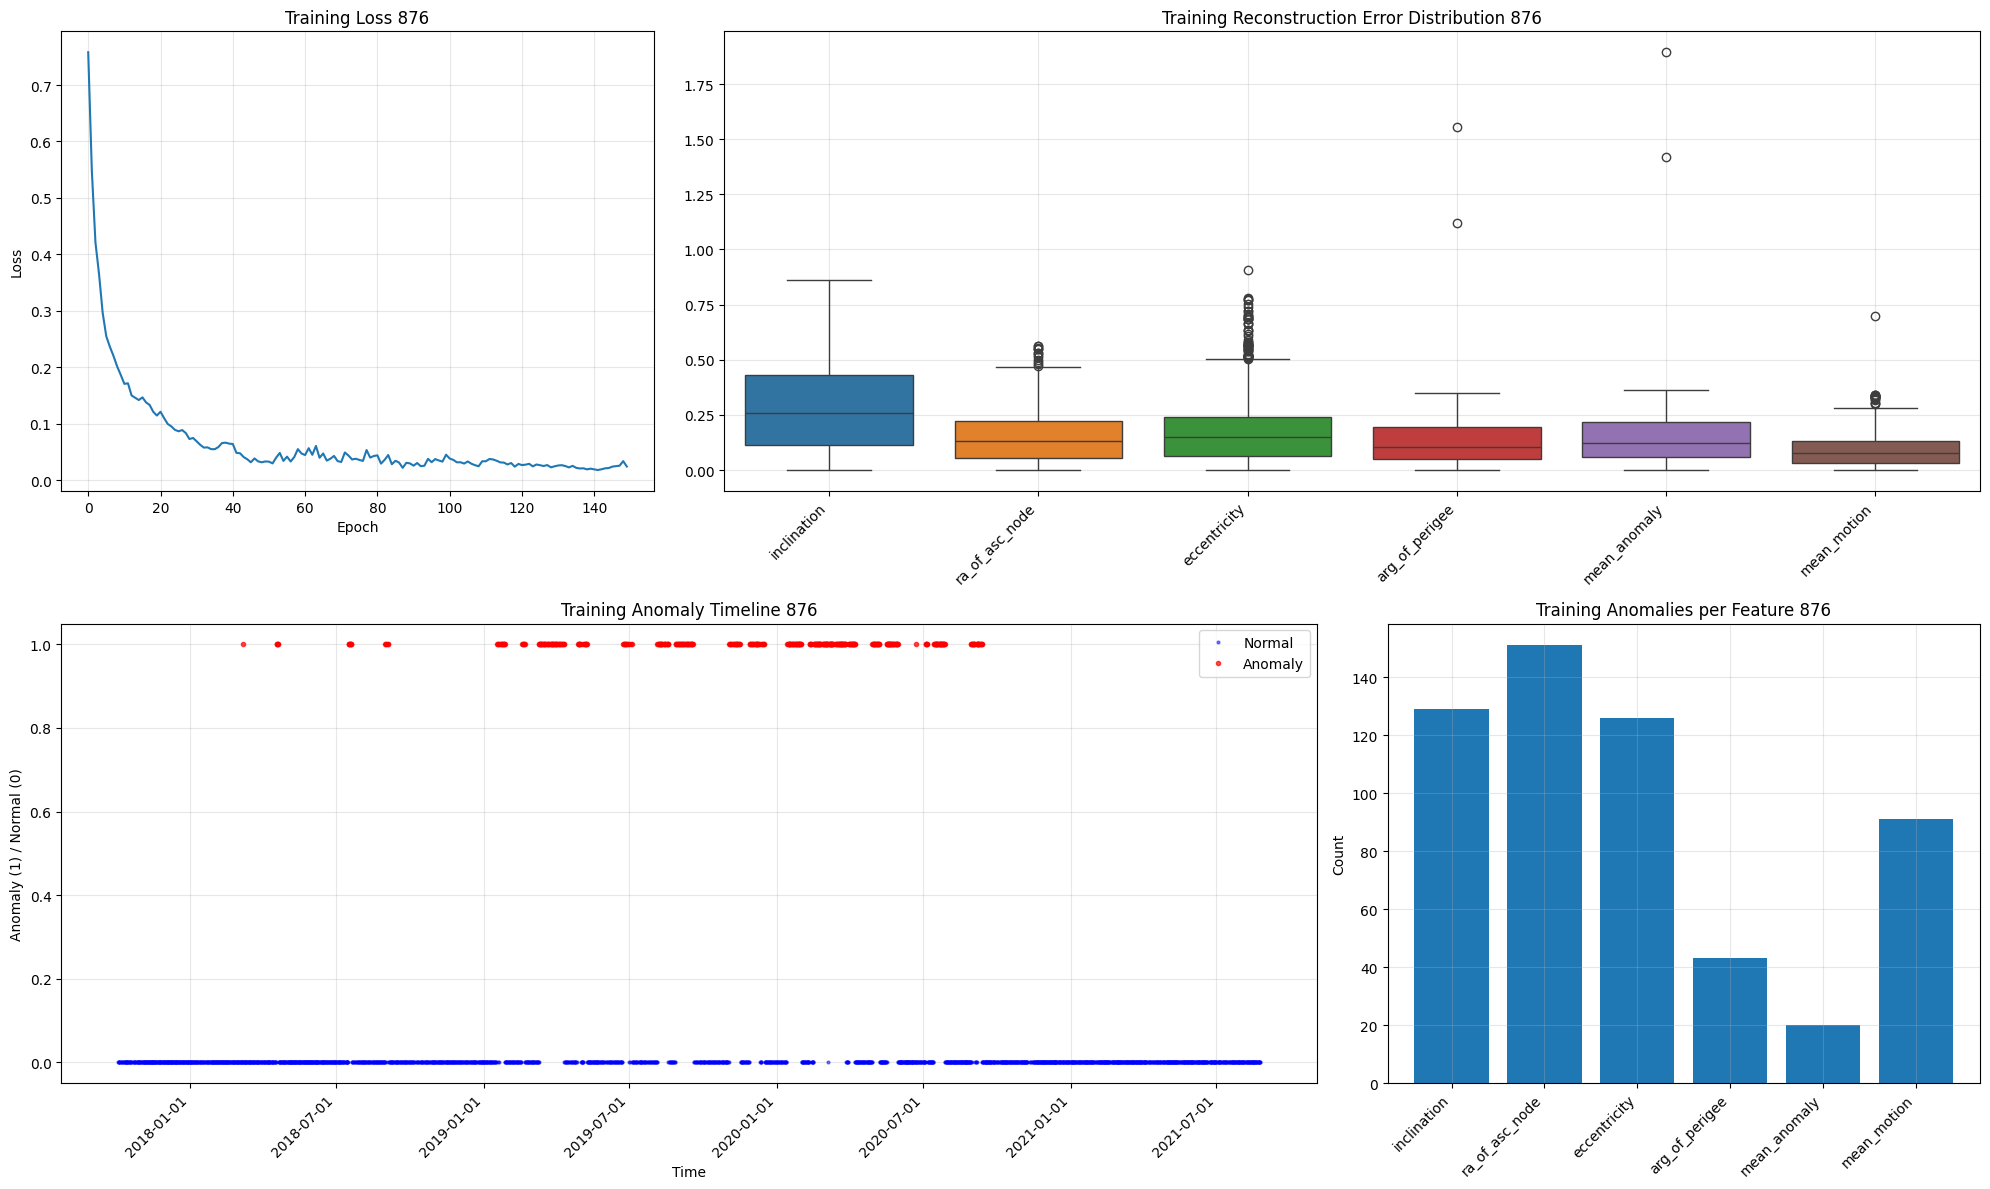

In [ ]:
def build_anom_model(NORAD_ID_NUM, test_size=0.2, random_state=42):
    os.makedirs(rf"C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\training_plots\plots_training_{NORAD_ID_NUM}", exist_ok=True)

    samp_df = df[df['NORAD_CAT_ID']==NORAD_ID_NUM]
    samp_df = samp_df.sort_values(by='datetime', ascending=False)
    orb_df = samp_df[['datetime','inclination','ra_of_asc_node', 'eccentricity', 
                      'arg_of_perigee', 'mean_anomaly', 'mean_motion']]
    orb_df = orb_df.set_index('datetime', drop=True)
    
    labels = samp_df['outlier'].values
    
    train_size = int((1 - test_size) * len(orb_df))
    X_train = orb_df.iloc[:train_size]
    X_test = orb_df.iloc[train_size:]
    y_train = labels[:train_size]
    y_test = labels[train_size:]

    X_train_size = X_train.shape[0]
    X_test_size = X_test.shape[0]
    train_cnt_outlier = np.sum(y_train > 0) 
    test_cnt_outlier = np.sum(y_test > 0)

    plot_save_dir = rf"C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\training_plots\plots_training_{NORAD_ID_NUM}"
    feature_names = list(orb_df)
    
    detector, anomalies, explanations, timestamps, anomaly_details = run_anomaly_detection_pipeline(
        X_train,
        feature_names=feature_names,
        model_path=r"C:\Users\dk412\Desktop\David\Python Projects\RusSat\anomaly_model",
        should_train=True,
        NORAD_ID_NUM=NORAD_ID_NUM,
        plot_save_dir=plot_save_dir
    )
    
    test_anomalies, test_anomaly_details = detector.detect_anomalies(X_test.values)
    
    metrics = {
        'accuracy': accuracy_score(y_test, test_anomalies),
        'precision': precision_score(y_test, test_anomalies, zero_division=0),
        'recall': recall_score(y_test, test_anomalies, zero_division=0),
        'f1': f1_score(y_test, test_anomalies, zero_division=0)
    }
    
    return {
        'train_data': X_train,
        'test_data': X_test,
        'train_labels': y_train,
        'test_labels': y_test,
        'test_predictions': test_anomalies,
        'metrics': metrics,
        'detector': detector,
        'anomalies': anomalies,
        'explanations': explanations,
        'timestamps': timestamps,
        'anomaly_details': anomaly_details,
        'full_sample': samp_df,
        'x_train_size': X_train_size,
        'x_test_size': X_test_size,
        'train_cnt_outlier': train_cnt_outlier,
        'test_cnt_outlier':test_cnt_outlier
    }

metrics_df = pd.DataFrame(columns=['NORAD_ID', 'accuracy', 'precision', 'recall', 'f1', 'x_train_size', 'x_test_size', 'train_cnt_outlier','test_cnt_outlier'])

unique_ids = df['NORAD_CAT_ID'].unique()[:3]
total_sats = len(unique_ids)

all_orbital_features = ['inclination', 'ra_of_asc_node', 'eccentricity', 
                       'arg_of_perigee', 'mean_anomaly', 'mean_motion']
anom_columns = [f'anom_{feat}' for feat in all_orbital_features]

for count, x in enumerate(unique_ids, 1):
    try:
        results = build_anom_model(x)

        metrics_row = {
            'NORAD_ID': x,
            'accuracy': results['metrics']['accuracy'],
            'precision': results['metrics']['precision'],
            'recall': results['metrics']['recall'],
            'f1': results['metrics']['f1'],
            'x_train_size': results['x_train_size'], 
            'x_test_size': results['x_test_size'], 
            'train_cnt_outlier': results['train_cnt_outlier'],
            'test_cnt_outlier': results['test_cnt_outlier']
        }
        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)

        metrics_df.to_csv(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\model_metrics.csv', index=False)
        
        anom_dict = {exp['sample_index']: [feat['feature'] for feat in exp['anomalous_features']] 
                    for exp in results['explanations']}    

        full_df = results['full_sample'].copy(deep=False)
        full_df.reset_index(inplace=True, drop=True)

        all_features = set().union(*[set(features) for features in anom_dict.values()]) 
        
        anom_df = pd.DataFrame(0, 
                            index=anom_dict.keys(),
                            columns=anom_columns)

        for key, features in anom_dict.items():
            anom_df.loc[key, [f'anom_{feat}' for feat in features]] = 1

        full_df = full_df.join(anom_df, how='left')
        full_df['anom_count'] = full_df.filter(like='anom_').sum(axis=1)
        full_df = full_df.fillna(0)

        for col in anom_columns:
            if col not in full_df.columns:
                full_df[col] = 0

        mode = 'w' if count == 1 else 'a'
        header = count == 1
        full_df.to_csv(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\anom_df_TRAIN_all_sats.csv', 
                       mode=mode, header=header, index=False)
        
        progress = count/df['NORAD_CAT_ID'].nunique()*100
        print(f"\nModel number {count} out of {df['NORAD_CAT_ID'].nunique()} complete. Progress: {progress:.3f}% done")
        
        del full_df, anom_df, anom_dict, results
        
    except Exception as e:
        print(f"Error processing NORAD ID {x}: {str(e)}")
        continue

************************************ WORKING

In [1]:
import os

In [48]:
files = os.listdir(r"C:\Users\dk412\Desktop\David\Python Projects\RusSat\output\inference_plots")

trained = list({int(f.split("_")[-1].strip("'\"")) for f in files})
trained
sat = df['NORAD_CAT_ID'].unique().tolist()

sats_to_train = list(set(sat) - set(trained))

In [6]:
print(f"Total satellites: {len(sat)}")
print(f"Already trained: {len(trained)}")
print(f"Need training: {len(sats_to_train)}")

Total satellites: 2544
Already trained: 5
Need training: 2539


In [36]:
test = sats_to_train[:10]
test

[8195, 16393, 16396, 16397, 16398, 32782, 16402, 16404, 16408, 16409]

In [8]:
import os
models = os.listdir(r"C:\Users\dk412\Desktop\David\Python Projects\RusSat\anomaly_model")
model_id = list(set({int(m.split("_")[0].strip("'\"")) for m in models}))

In [10]:
model_id

[1570, 746, 829, 876, 877]

In [53]:
refire = False

In [54]:
unique_id = [12,232,343]

In [55]:
if refire:
    id_lst = test
else:
    id_lst = unique_ids


In [56]:
id_lst

array([ 746,  829,  876,  877, 1570])